# Helper functions

In [1]:
import pandas as pd
import json

d4j_perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

bears_perturbed_bugs = {"Bears-140","Bears-1","Bears-194","Bears-196","Bears-213",
                        "Bears-205","Bears-232","Bears-204","Bears-98","Bears-251",
                        "Bears-153","Bears-180","Bears-165","Bears-207","Bears-198",
                        "Bears-186","Bears-210","Bears-190","Bears-241","Bears-166",
                        "Bears-199","Bears-200","Bears-234","Bears-240","Bears-250",
                        "Bears-223","Bears-144","Bears-212","Bears-214","Bears-169",
                        "Bears-242","Bears-246","Bears-156","Bears-84","Bears-238",
                        "Bears-157","Bears-202","Bears-231","Bears-243","Bears-247",
                        "Bears-233","Bears-239","Bears-220","Bears-245","Bears-158",
                        "Bears-209","Bears-188","Bears-229","Bears-193","Bears-230",
                        "Bears-211","Bears-221","Bears-222","Bears-228","Bears-248",
                        "Bears-201","Bears-224","Bears-176","Bears-27","Bears-227",
                        "Bears-249","Bears-142","Bears-225","Bears-159","Bears-170",
                        "Bears-197","Bears-226","Bears-184","Bears-177","Bears-149",
                        "Bears-206","Bears-155"}

def read_eval_d4j(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(d4j_perturbed_bugs)]
    return df

def read_eval_bears(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(bears_perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df, k):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            all_count += 1
            if fix["compile_exec"] and fix["compile_pass"]:
                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_test(df, k):
    count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                count += 1
                break
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_bugs_test(df, k=100):
    count = 0
    bugs = set()
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            if (fix["test_exec"] and fix["test_pass"]) or fix["identical"]:
                bugs.add(index)
                break
    return bugs

In [5]:
def get_table_entry(model_label, rounds, cb, tb, cd, td):
    return {"Model": {
                "" :   { "" : model_label }
            },
            "Testing":{
                "Bears Compile" : dict(zip(rounds, cb)),
                "Bears Test Adequacy" : dict(zip(rounds, tb)),
                "Defects4J Compile" : dict(zip(rounds, cd)),
                "Defects4J Test Adequacy" : dict(zip(rounds, td))
            }
       }

In [6]:
ex_label = { "defects4j_buglab" : "Defects4J x Buglab",
            "defects4j_selfapr" : "Defects4J x SelfAPR",
            "bears_buglab" : "Bears x Buglab",
            "bears_selfapr" : "Bears x SelfAPR",
           }
round_label = { "round0" : "Initialization",
               "round1-nocritic" : "Initialization + BIFI4J(keepall)",
               "round1-compiler" : "Initialization + BIFI4J(compiler)",
               "round1-tests" : "Initialization + BIFI4J(tests)",
              }


def get_model_label(ex, ro):
    return ex_label[ex] + ": " + round_label[ro]

# Results Table

In [7]:
from os.path import exists

entries = []
#top_k = [1, 5, 10, 25, 50, 100]
top_k = [100]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_bears_bw_100.json" % (ex, ro_path)
        bears_path_single_hunk = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_defects4j_bw_100.json" % (ex, ro_path)
        d4j_path_single_hunk = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)
        
        read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
        cb = [get_number_compile(read_eval(bears_path_single_hunk), k) for k in top_k] if exists(bears_path_single_hunk) else ["N/A" for _ in top_k]
        tb = [get_number_test(read_eval(bears_path_single_hunk), k) for k in top_k] if exists(bears_path_single_hunk) else ["N/A" for _ in top_k]
        cd = [get_number_compile(read_eval(d4j_path_single_hunk), k) for k in top_k] if exists(d4j_path_single_hunk) else ["N/A" for _ in top_k]
        td = [get_number_test(read_eval(d4j_path_single_hunk), k) for k in top_k] if exists(d4j_path_single_hunk) else ["N/A" for _ in top_k]
        
        entries += [get_table_entry(get_model_label(ex, ro) , top_k, cb, tb, cd, td)]

In [8]:
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table

Model              Testing  \
                                                             Bears Compile   
                                                                       100   
0                  Defects4J x Buglab: Initialization   201 / 5800 (3.47%)   
1   Defects4J x Buglab: Initialization + BIFI4J(ke...                  N/A   
2   Defects4J x Buglab: Initialization + BIFI4J(co...                  N/A   
3   Defects4J x Buglab: Initialization + BIFI4J(te...                  N/A   
4                 Defects4J x SelfAPR: Initialization   119 / 5800 (2.05%)   
5   Defects4J x SelfAPR: Initialization + BIFI4J(k...   181 / 5800 (3.12%)   
6   Defects4J x SelfAPR: Initialization + BIFI4J(c...                  N/A   
7   Defects4J x SelfAPR: Initialization + BIFI4J(t...                  N/A   
8                      Bears x Buglab: Initialization  632 / 3700 (17.08%)   
9    Bears x Buglab: Initialization + BIFI4J(keepall)                  N/A   
10  Bears x Buglab: Initialization + BIFI4J(compiler)                  N/A   
11     Bears x Buglab: Initialization + BIFI4J(tests)                  N/A   
12                    Bears x SelfAPR: Initialization  886 / 3700 (23.95%)   
13  Bears x SelfAPR: Initialization + BIFI4J(keepall)                  N/A   
14  Bears x SelfAPR: Initialization + BIFI4J(compi...                  N/A   
15    Bears x SelfAPR: Initialization + BIFI4J(tests)                  N/A   

                                                                       
   Bears Test Adequacy      Defects4J Compile Defects4J Test Adequacy  
                   100                    100                     100  
0       4 / 58 (6.90%)  7071 / 47900 (14.76%)        23 / 479 (4.80%)  
1                  N/A                    N/A                     N/A  
2                  N/A                    N/A                     N/A  
3                  N/A                    N/A                     N/A  
4      6 / 58 (10.34%)                    N/A                     N/A  
5      9 / 58 (15.52%)                    N/A                     N/A  
6                  N/A                    N/A                     N/A  
7                  N/A                    N/A                     N/A  
8       2 / 37 (5.41%)                    N/A                     N/A  
9                  N/A                    N/A                     N/A  
10                 N/A                    N/A                     N/A  
11                 N/A                    N/A                     N/A  
12     7 / 37 (18.92%)  6341 / 48600 (13.05%)       54 / 486 (11.11%)  
13                 N/A  8290 / 48600 (17.06%)       67 / 486 (13.79%)  
14                 N/A                    N/A                     N/A  
15                 N/A                    N/A                     N/A

# RQ1: To what extent does the perturbation model choice impact the model's repair accuracy?

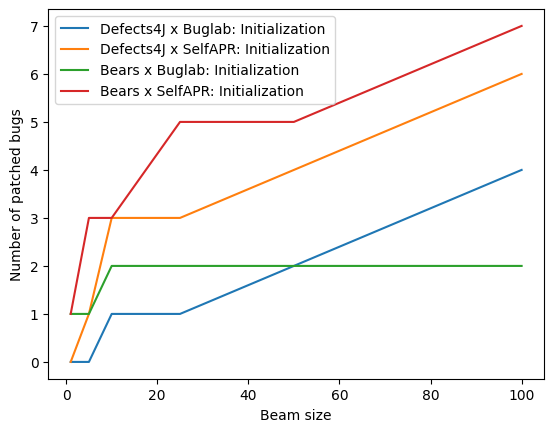

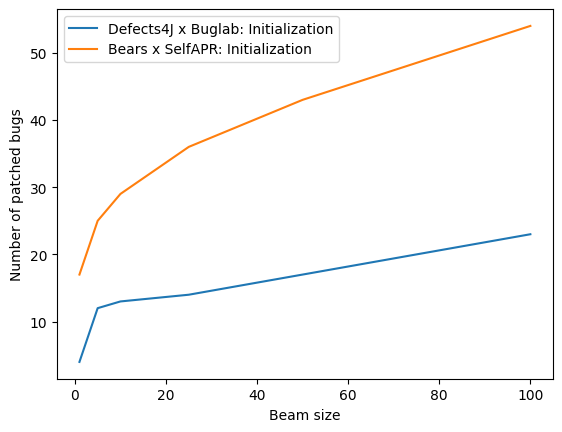

In [9]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]

plt.figure("defects4j")
plt.figure("bears")

for ex in experiments:
    read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
    bears_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_bears_bw_100.json" % ex
    d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_defects4j_bw_100.json" % ex

    if exists(bears_path):
        tb = [int(get_number_test(read_eval(bears_path), k).split("/")[0]) for k in top_k]
        plt.figure("bears")
        plt.plot(top_k, tb, label=get_model_label(ex, "round0"))
        
    if exists(d4j_path):
        td = [int(get_number_test(read_eval(d4j_path), k).split("/")[0]) for k in top_k] 
        plt.figure("defects4j")
        plt.plot(top_k, td, label=get_model_label(ex, "round0"))

plt.figure("bears")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")

plt.figure("defects4j")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")

plt.show()

# RQ2: To what extent does the BIFI setup, and the critic choice, impact the repair accuracy?

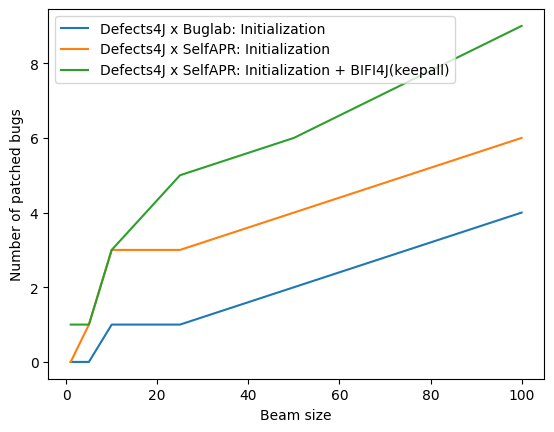

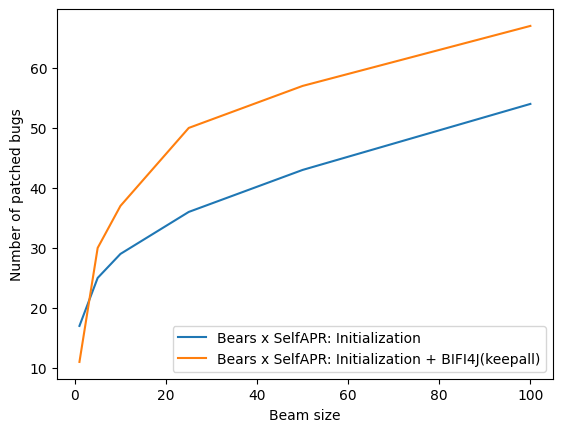

In [10]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j")
plt.figure("bears")

for ex in experiments:
    read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                tb = [int(get_number_test(read_eval(bears_path), k).split("/")[0]) for k in top_k]
                plt.figure("bears")
                plt.plot(top_k, tb, label=get_model_label(ex, ro))

        if "bears" in ex:
            if exists(d4j_path):
                td = [int(get_number_test(read_eval(d4j_path), k).split("/")[0]) for k in top_k] 
                plt.figure("defects4j")
                plt.plot(top_k, td, label=get_model_label(ex, ro))

plt.figure("bears")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")

plt.figure("defects4j")
plt.legend()
plt.xlabel("Beam size")
plt.ylabel("Number of patched bugs")
                
plt.legend()
plt.show()

### What bugs can round1-X fix that round0 cannot?

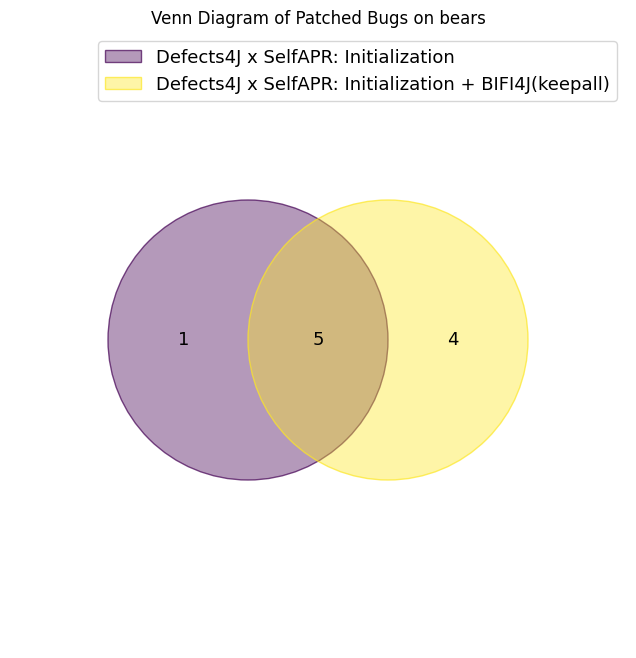

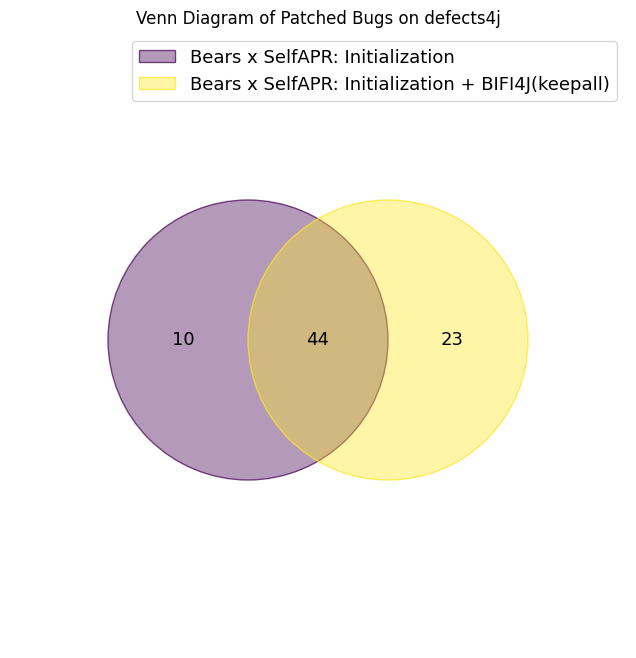

In [11]:
from os.path import exists
from venn import venn
import matplotlib.pyplot as plt
%matplotlib inline

experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
bifi_rounds = ["round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
    eval_dataset = "defects4j" if "bears" in ex else "bears"
    
    path = "/mnt/data/andre/mscthesis/experiments/%s/round0/fixer/eval_single_hunk_%s_bw_100.json" % (ex, eval_dataset)
    if not exists(path): continue
    patches = {get_model_label(ex, "round0") : get_bugs_test(read_eval(path))}
    
    for ro in bifi_rounds:
        path = "/mnt/data/andre/mscthesis/experiments/%s/%s/part2/fixer/eval_single_hunk_%s_bw_100.json" % (ex, ro, eval_dataset)
        if not exists(path): continue
        patches[get_model_label(ex, ro)] = get_bugs_test(read_eval(path))

    if len(patches) >= 2:
        venn(patches)
        plt.title("Venn Diagram of Patched Bugs on %s" % eval_dataset)
        plt.show()

# RQ3: To what extent does the BIFI setup, and the critic choice, impact the compilability of generated patches?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


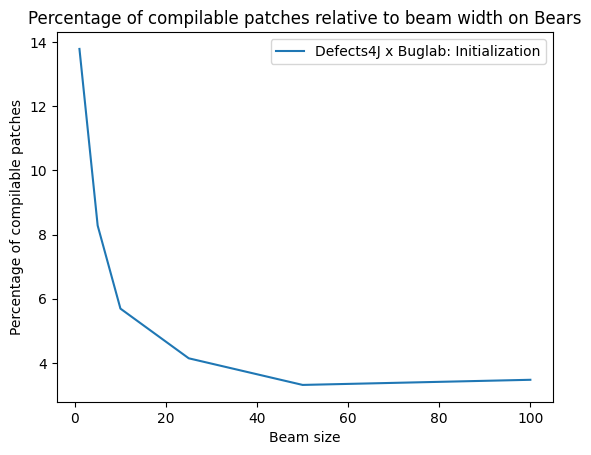

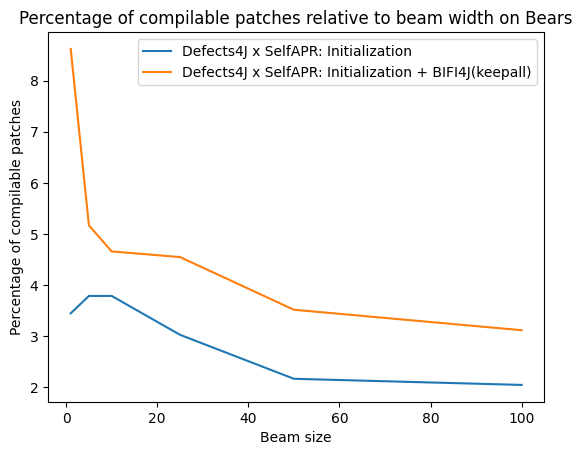

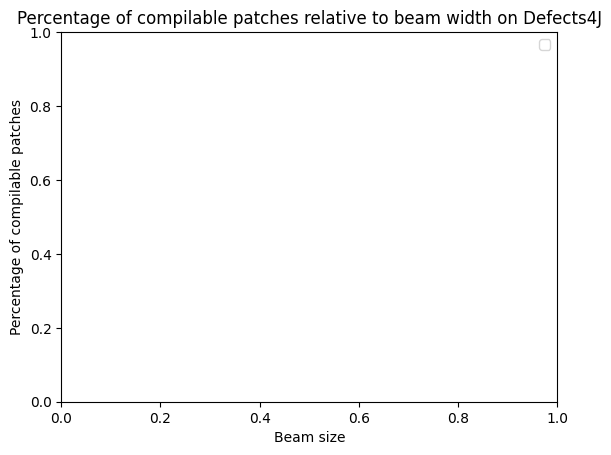

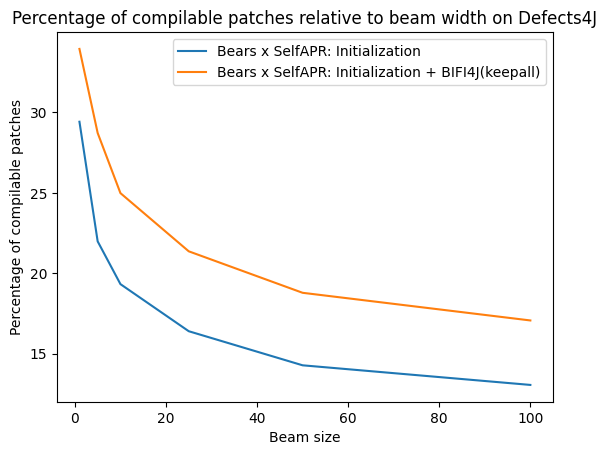

In [12]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

plt.figure("defects4j_buglab")
plt.figure("defects4j_selfapr")
plt.figure("bears_buglab")
plt.figure("bears_selfapr")

for ex in experiments:
    read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_bears_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_single_hunk_defects4j_bw_100.json" % (ex, ro_path)

        if "defects4j" in ex:
            if exists(bears_path):
                cb = [float(get_number_compile(read_eval(bears_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cb, label=get_model_label(ex, ro))

        if "bears" in ex:
            if exists(d4j_path):
                cd = [float(get_number_compile(read_eval(d4j_path), k).split("(")[1].split("%")[0]) for k in top_k]
                plt.figure(ex)
                plt.plot(top_k, cd, label=get_model_label(ex, ro))

for ex in experiments:
    plt.figure(ex)
    plt.legend()
    plt.title("Percentage of compilable patches relative to beam width on %s" % ("Defects4J" if "bears" in ex else "Bears"))
    plt.xlabel("Beam size")
    plt.ylabel("Percentage of compilable patches")
                
plt.legend()
plt.show()